### Complejidad - Práctico 4/6 - Generación procedural de terrenos
#### Lautaro Giordano

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

In [150]:
class cueva:
    def __init__(self, width, height, prob_pared, seed=None):
        self.width = width
        self.height = height
        self.prob_pared = prob_pared
        # El default es seed=None que me da una semilla aleatoria.
        self.seed = seed
        np.random.seed(self.seed)
        self.cueva = self.generar_cueva()
        self.bordes = self.calcular_bordes()
    

    def generar_cueva(self):
        cueva = np.ones((self.height, self.width))

        # Los bordes siempre son unos (paredes).
        for i in range(1, self.height - 1):
            for j in range(1, self.width - 1):
                cueva[i][j] = 1 if np.random.random() < self.prob_pared else 0
        
        return cueva

    
    def calcular_bordes(self):
        bordes = np.zeros((self.height, self.width))
        valor_borde = 1

        for i in range(self.height):
            for j in range(self.width):
                # Si la celda actual no es una pared, no forma parte del borde
                if self.cueva[i][j] == 0:
                    continue
                # Chequeo si las paredes del rectangulo son parte del borde
                elif i == 0:
                    if self.cueva[i+1][j] == 0:
                        bordes[i][j] = valor_borde
                elif i == self.height - 1:
                    if self.cueva[i-1][j] == 0:
                        bordes[i][j] = valor_borde 
                elif j == 0: 
                    if self.cueva[i][j+1] == 0:
                        bordes[i][j] = valor_borde
                elif j == self.width - 1:
                    if self.cueva[i][j-1] == 0:
                        bordes[i][j] = valor_borde
                
                else:
                    # Miro a primeros vecinos de una celda
                    # Si hay algún vecino que no es una pared, la celda actual es un borde
                    if self.cueva[i+1][j] == 0 or self.cueva[i-1][j] == 0 or self.cueva[i][j+1] == 0 or self.cueva[i][j-1] == 0:
                        bordes[i][j] = valor_borde
        return bordes
       

    def plot_cueva(self, bordes=False):
        combined = self.cueva.copy()

        if bordes:
            self.bordes = self.calcular_bordes()
            combined[self.bordes == 1] = 2  # Pared que es borde

            # Defino el mapa de colores: 0 = blanco, 1 = negro, 2 = rojo
            cmap = mcolors.ListedColormap(['white', 'black', 'red'])

        else:
            cmap = mcolors.ListedColormap(['white', 'black'])

        fig, ax = plt.subplots()
        ax.imshow(combined, cmap=cmap)
        
        ax.axis('off')
        plt.show()

    def paso_suavizar_cueva(self):
        cueva = self.cueva.copy()
        # No miro los bordes
        for i in range(1, self.height - 1):
            for j in range(1, self.width - 1):
                # Miro a primeros vecinos de una celda
                vecindad = cueva[i-1:i+2, j-1:j+2]
                # Si hay más de 5 celdas con pared, pongo una pared (regla del automata)
                if np.sum(vecindad) >= 5:
                    self.cueva[i][j] = 1
                # Si hay menos de 3 celdas con pared, pongo un espacio vacío
                elif np.sum(vecindad) <= 3:
                    self.cueva[i][j] = 0
                # Si hay 4 celdas con pared, dejo como está


    def suavizar_cueva(self, n_its=5):
        for _ in range(n_its):
            self.paso_suavizar_cueva()

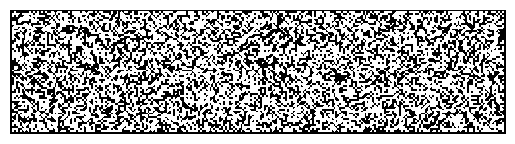

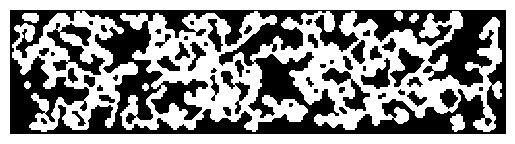

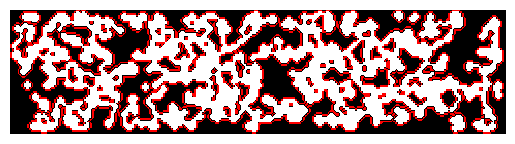

In [151]:
width, height = 256, 64

cueva = cueva(width, height, 0.42, seed=1)
cueva.plot_cueva(bordes=False)
cueva.suavizar_cueva(50)
cueva.plot_cueva()
cueva.plot_cueva(bordes=True)

Dimension fractal: 1.79 +- 0.03


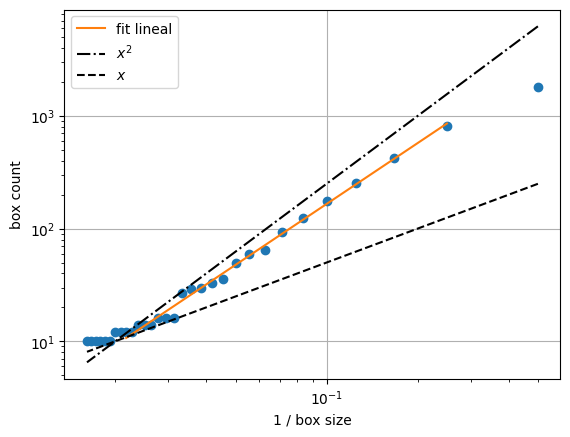

In [152]:
# Ahora quiero hacer box counting sobre los bordes y estimar su dimension fractal
# Para eso, primero necesito encontrar los bordes de la cueva
# Luego, hago un box counting sobre los bordes
# Finalmente, hago un ajuste lineal para encontrar la dimensión fractal

# Encuentro los bordes de la cueva
bordes = cueva.calcular_bordes()

# Hago box counting sobre los bordes
def box_counting(bordes, box_size):
    # Cuento cuántos cuadrados de tamaño box_size necesito para cubrir los bordes
    n_boxes_x = int(np.ceil(bordes.shape[1] / box_size))
    n_boxes_y = int(np.ceil(bordes.shape[0] / box_size))

    boxes = np.zeros((n_boxes_y, n_boxes_x))

    for i in range(n_boxes_y):
        for j in range(n_boxes_x):
            # Cuento cuántos bordes hay en el cuadrado
            box = bordes[i*box_size:(i+1)*box_size, j*box_size:(j+1)*box_size]
            boxes[i, j] = np.sum(box)

    return np.sum(boxes > 0)

box_sizes = np.arange(2, 64, 2)
inverse_box_sizes = 1 / np.array(box_sizes)
box_counts = [box_counting(bordes, box_size) for box_size in box_sizes]

plt.plot(inverse_box_sizes, box_counts, 'o')
plt.xscale('log')
plt.yscale('log')
plt.grid()

# Hago un ajuste lineal para encontrar la dimensión fractal
from scipy.stats import linregress

# Fiteo solo una zona
sliced_inverse_size = inverse_box_sizes[1:-8]
sliced_box_count = box_counts[1:-8]

slope, intercept, _, _, std_err = linregress(np.log(sliced_inverse_size), np.log(sliced_box_count))
plt.plot(sliced_inverse_size, np.exp(intercept) * sliced_inverse_size**slope, label=f'fit lineal')

# Ploteo x^2
plt.plot(inverse_box_sizes,2.5e4 * inverse_box_sizes**2, 'k-.', label=r'$x^2$')
plt.plot(inverse_box_sizes,5e2 * inverse_box_sizes, 'k--', label=r'$x$')

plt.xlabel('1 / box size')
plt.ylabel('box count')
plt.legend()

print(f'Dimension fractal: {slope:.2f} +- {std_err:.2f}')


plt.show()